## 1. IMPORTING ALL REQUIRE LIBRARIES

In [34]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import sklearn
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures

In [5]:
pd.set_option("display.max_columns", None)

In [6]:
sklearn.set_config(transform_output="pandas")

In [7]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
val_df = pd.read_csv('data/val.csv')

In [8]:
train_df.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187


In [9]:
def split_data(data):
    x = data.drop(columns='price')
    y = data['price']
    return x, y

In [10]:
x_train, y_train = split_data(train_df)


In [11]:
x_train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info


In [12]:
y_train.head()

0    4995
1    8372
2    6117
3    7770
4    9187
Name: price, dtype: int64

In [13]:
x_val, y_val = split_data(val_df)
x_test, y_test = split_data(test_df)

In [14]:
print("SHAPE TRAIN:-",x_val.shape, y_val.shape)

SHAPE TRAIN:- (160, 9) (160,)


In [15]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


### DATA PREPROCESSING :-

In [16]:
dt_cols = ['date_of_journey', 'dep_time', 'arrival_time']
num_cols = ['duration', 'total_stops']
cat_cols = [col for col in x_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [76]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scalar", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

doj_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=['month', 'week', 'day_of_week', 'day_of_month'], format="mixed")),
    ("scalar", StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=['hour', 'minute'], format="mixed")),
    ("scalar", StandardScaler())
])

In [77]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ['date_of_journey']),
    ("time", time_transformer, ['dep_time', 'arrival_time'])
])

In [78]:
train_df.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

In [79]:
preprocessor.fit_transform(x_train)

,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,-1.095918,-1.212132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.151587,1.331443,0.566118,0.963554,-0.462055,-0.140057,-0.345231,1.493859
1,1.435699,0.317975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,1.050498,0.604465,-0.640951,-1.229863,-0.935607,0.891041
2,1.824412,1.848082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,1.140212,-0.402640,-0.113711,-0.640951,-0.684960,-0.345231,-1.218823
3,1.904148,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.772093,-1.371399,-1.430369,1.326906,-0.140057,1.278301,1.795268
4,0.847647,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,0.948982,0.081739,-0.831888,0.790218,-1.229863,-0.492825,1.192450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.936446,-1.212132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.580863,0.566118,-0.113711,-1.535432,1.767103,-0.935607,1.192450
636,0.100122,0.317975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.184059,0.081739,-0.472800,-0.640951,0.677297,1.130707,-1.218823
637,-0.946413,-1.212132,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-1.177640,-0.957412,-0.788013,1.493859
638,0.189825,0.317975,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-0.819847,1.222200,1.130707,-1.520232


### MODEL SELECTION

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

In [81]:
algorithm = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators = 10)
}

In [82]:
data = pd.concat([train_df, val_df], axis=0)
X_data, y_data = split_data(data)

In [83]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
                sizes, 
                mean_scores,
                marker = "o",
                label = label
    )
    
    ax.fill_between(
                x = sizes,
                y1 = mean_scores - std_scores,
                y2 = mean_scores + std_scores,
                alpha = 0.5
    )

In [84]:
def plot_learning_curves(name, algorithm, figsize = (12, 4)):
    model = Pipeline(steps=[
                    ("pre", preprocessor),
                    ("alg", algorithm)
    ])
    
    train_size, train_scores, test_scores = learning_curve(
                    estimator=model,
                    X = x_data, 
                    y = y_data,
                    cv = 3, 
                    scoring = "r2",
                    n_jobs = -1, 
                    random_state = 42
    )
    
    mean_train_scores = np.mean(train_scores, axis = 1)
    std_train_scores = np.std(train_scores, axis = 1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    
    mean_test_scores = np.mean(test_scores, axis = 1)
    std_test_scores = np.std(test_scores, axis = 1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {mean_test_scores[-1]:.2f}"
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # for train curve
    plot_curves(
                    train_size,
                    mean_train_scores,
                    std_train_scores,
                    f"Train ({train_score})",
                    ax
    )
    
    # for test curve
    plot_curves(
                    train_size,
                    mean_test_scores,
                    std_test_scores,
                    f"Test ({test_score})",
                    ax
    )
    
    ax.set(xlabel = "Training set size", ylabel = "R-square", title = name)
    ax.legend(loc = "lower right")
    plt.show()

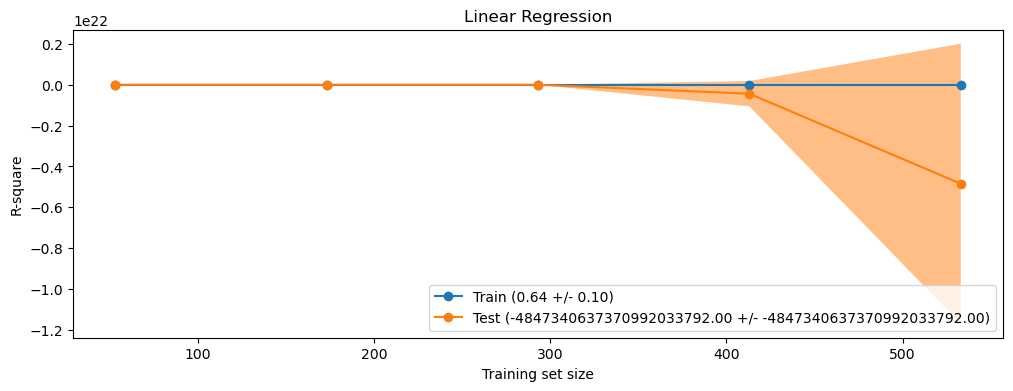

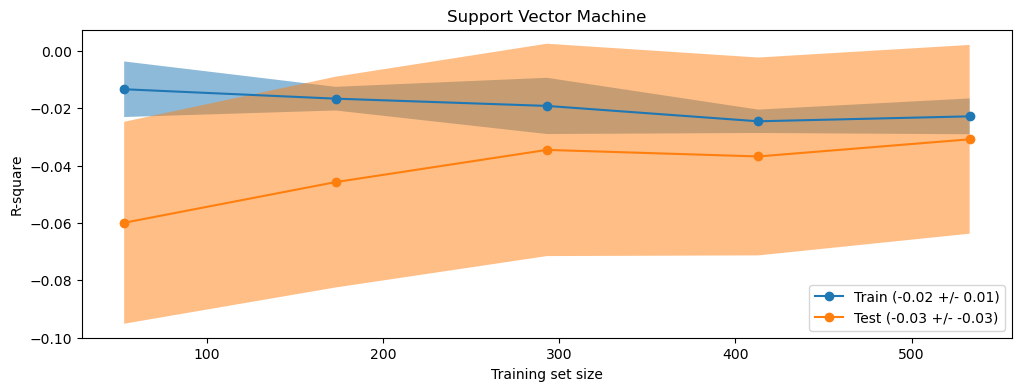

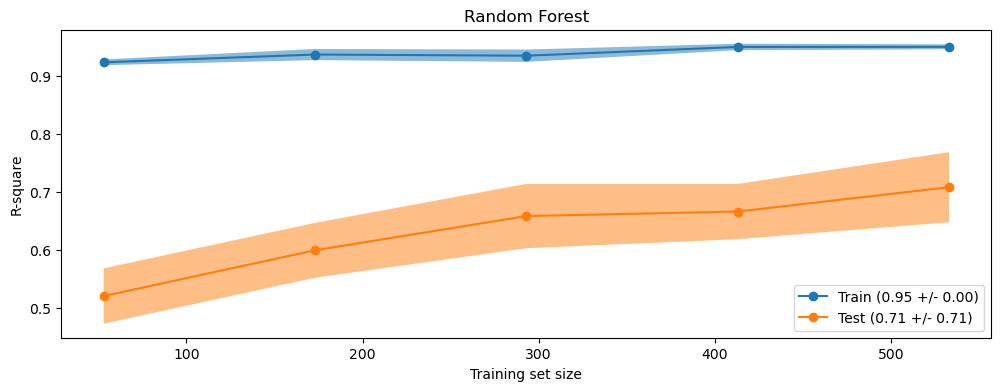

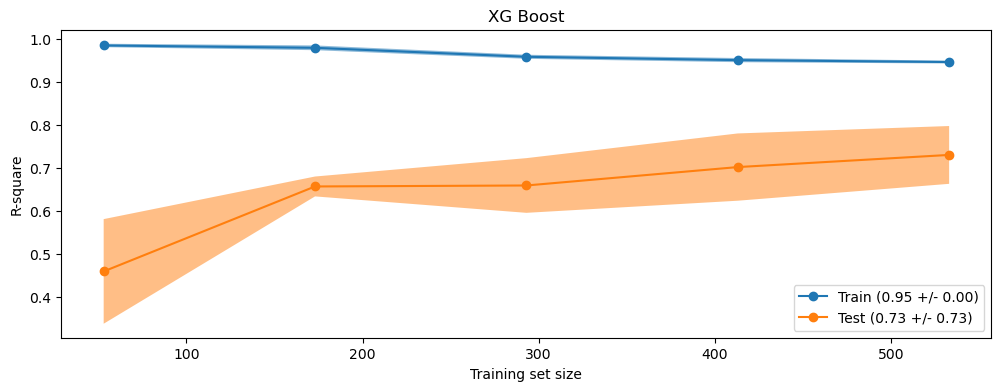

In [85]:
for name, alg in algorithm.items():
    plot_learning_curves(name, alg)

### MODEL TRAINING 

In [65]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("XG Boost", XGBRegressor(n_estimators = 10))
])


In [66]:
model.fit(x_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['airline', 'source',
                                                   'destination',
                                                   'additional...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=10, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [69]:
def evaluate_model(X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [70]:
evaluate_model(x_data, y_data)

0.9289921522140503

In [71]:
evaluate_model(x_test, y_test)

0.7367968559265137

In [72]:
evaluate_model(x_val, y_val)

0.9309334754943848

### 8. MODEL PRESISTANCE

In [73]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [74]:
saved_model = joblib.load('model.joblib')

In [75]:
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['airline', 'source',
                                                   'destination',
                                                   'additional...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=10, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])